# Analysis of previous forecasts

### Define script parameters

In [127]:
valid_time = "2024-09-12 15"
variable = "tp"  # options: "tp", "wind_speed", "tcwv"

In [128]:
figname = f"ECMWF_operational_verf_{variable}_{valid_time}.png"
figname = figname.replace("-", "").replace(" ", "_")
print("Figures saved in: ", figname)

Figures saved in:  ECMWF_operational_verf_tp_20240912_15.png


### Main script

In [129]:
import intake
import numpy as np

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import easygems.healpix as egh
import pandas as pd
import matplotlib

from wblib.figures.hifs import HifsForecasts
from wblib.figures.briefing_info import INTERNAL_FIGURE_SIZE
from wblib.figures.briefing_info import ORCESTRA_DOMAIN

In [130]:
CATALOG_URL = "https://tcodata.mpimet.mpg.de/internal.yaml"
VARIABLE_LEVES = {
    "wind_speed": 3,
    "tcwv": 48,
    "tp": 10
}
VARIABLE_LEADS = {
    "wind_speed": 6,
    "tcwv": 6,
    "tp": 6       
}
VARIABLE_DIFF = {
    "10u": False,
    "10v": False,    
    "tcwv": False,
    "tp": True       
}
VARIABLE_UNITS= {
    "10u": None,
    "10v": None,  
    "tcwv": None,
    "tp": "D"    
}

In [131]:
def get_forecast_data(
    valid_time,
    lead_hours_str,
    variable,
    refhour_validtime=15,
    refhour_issuetime=0,
):
    if variable == "wind_speed":
        u10m = _get_forecast_data(
            valid_time,
            lead_hours_str,
            "10u",
            refhour_validtime,
            refhour_issuetime,
        )
        v10m = _get_forecast_data(
            valid_time,
            lead_hours_str,
            "10v",
            refhour_validtime,
            refhour_issuetime,
        )
        windspeed_10m = np.sqrt(u10m**2 + v10m**2)
        windspeed_10m = windspeed_10m.assign_attrs(
            {"long_name": "Wind speed", "units": "m s^-1"}
        )
        windspeed_10m.name = "wind_speed"
        return windspeed_10m
    forecast = _get_forecast_data(
        valid_time,
        lead_hours_str,
        variable,
        refhour_validtime,
        refhour_issuetime,
    )
    if variable == "tp":
        forecast = 1000 * forecast
    return forecast


def _get_forecast_data(
    valid_time, lead_hours_str, variable, refhour_validtime, refhour_issuetime
):
    valid_time = _check_datetime(valid_time, refhour=refhour_validtime)
    lead = pd.Timedelta(hours=int(lead_hours_str[:-1]))
    issued_time = valid_time - lead
    issued_time = _check_datetime(issued_time, refhour=refhour_issuetime)

    cat = intake.open_catalog(CATALOG_URL)
    hifs = HifsForecasts(cat)
    hifs_issued_time, data = hifs.get_forecast(
        variable,
        issued_time,
        lead_hours_str,
        pd.Timestamp.now("UTC").tz_localize(None),
        differentiate=VARIABLE_DIFF[variable],
        differentiate_unit=VARIABLE_UNITS[variable],
    )
    assert issued_time == hifs_issued_time, "Wrong issue time in HIFS"
    return data


def _check_datetime(datetime, refhour=15):
    new_datetime = pd.Timestamp(datetime)
    if new_datetime.hour != refhour:
        raise NotImplementedError(f"Ony time={refhour} is implemented.")
    return new_datetime

In [132]:
def format_axes(ax, crs=ccrs.PlateCarree()):
    lon_min, lon_max, lat_min, lat_max = ORCESTRA_DOMAIN
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.coastlines(lw=1.0, color="k")
    ax.set_xticks(np.round(np.linspace(-70, 10, 9), 0), crs=crs)
    ax.set_yticks(np.round(np.linspace(-20, 20, 5), 0), crs=crs)
    ax.set_ylabel("Latitude / \N{DEGREE SIGN}N")
    ax.set_xlabel("Longitude / \N{DEGREE SIGN}E")
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])

In [133]:
n_lead = VARIABLE_LEADS[variable]
lead_times = [15 + 24*i for i in range(n_lead)]
lead_times.reverse()
lead_times_strs = [f"{value:02d}H" for value in lead_times]
alphas = np.linspace(0.5, 1, n_lead)
cmap = matplotlib.colormaps['viridis_r']
colors = cmap(np.linspace(0, 0.5, n_lead))
legend_elements = [
    plt.Line2D([0], [0], color=color, label=f'Lead {lead} hours')
    for color, lead in zip(colors, lead_times)
    ]
legend_elements.append(plt.Line2D([0], [0], color="k", label=f'Lead 3 hours'))

In [134]:
forecasts = []
for lead_times_str in lead_times_strs:
    forecast = get_forecast_data(
        valid_time,
        lead_times_str,
        variable,
        refhour_validtime=15,
        refhour_issuetime=0,
    )
    forecasts.append(forecast)
analysis = get_forecast_data(
    valid_time, "003H", variable, refhour_validtime=15, refhour_issuetime=12
)

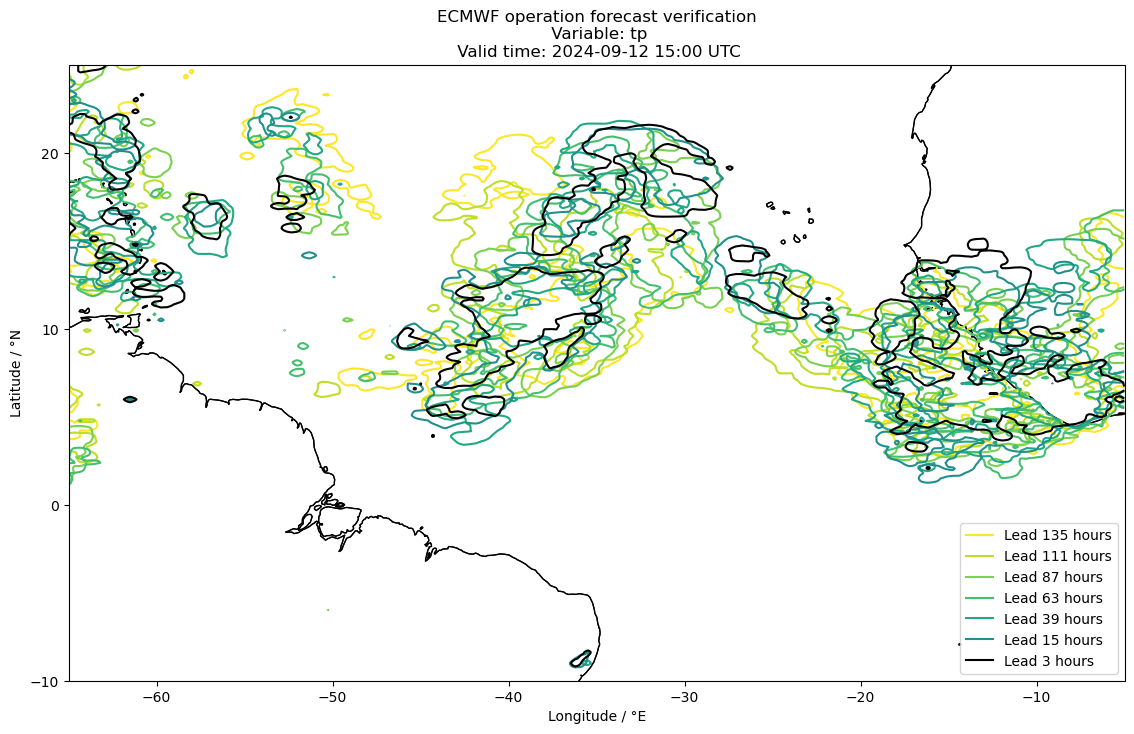

In [135]:
fig, ax = plt.subplots(figsize=INTERNAL_FIGURE_SIZE, 
                       subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-65, -5, -10, 25])
ax.coastlines(lw=0.8)
for i, forecast in enumerate(forecasts):
    cs = egh.healpix_contour(
        forecast,
        method="linear",
        colors=[colors[i]],
        #alpha=alphas[i],
        levels=[VARIABLE_LEVES[variable]],
    )
egh.healpix_contour(
    analysis,
    method="linear",
    colors=["k"],
    levels=[VARIABLE_LEVES[variable]],
)
format_axes(ax)
ax.legend(handles=legend_elements, loc='lower right')
ax.set_title("ECMWF operation forecast verification"
             f"\n Variable: {variable}"
             f"\n Valid time: {valid_time}:00 UTC")
plt.savefig(figname)